# Noiseless simulation of the FSL method for multivariate functions

In our paper, we argued that the FSL method can be used to load a multivariate functions on a quantum state. As an example, we presented the result of a noiseless simulation of loading a two-dimensional sinc function as shown in Fig. (3) of our paper. In this notebook, we perform a simulation of using the FSL method for loading the two-dimensional sinc function. Even though we only consider the sinc function in this notebook, the code that we present can be used for loading any two-dimensional function. 

We first import useful libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Qiskit 
import qiskit
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit.library import QFT

# Custom libraries
import supplementary
import uniformly_controlled_rotations as UCR

## Two-dimensional FSL method

Consider a quantum state of $2n$-qubits defined as 

$$ |f\rangle \, = \, \sum_{j=0}^{2^{n}-1}\sum_{j=0}^{2^{n}-1} \, f_{j,k} |j\rangle \otimes |k\rangle \, ,$$

where $f_{j,k}$ is the value of a function $f(x,y)$ at points $x = j/2^{n}$ and $y=k/2^{n}$. 

This quantum state can be prepared with high fidelity using the following quantum circuit.


<img src="figures/2d_fsl_circuit.jpg" alt="Two-dimensional FSL circuit" style="height: 300px; width:400px;"/>

In this circuit, the unitary $U_{c}$ prepares the following quantum state of $2(m+1)$ qubits which encodes the first $2^{2(m+1)}$ two-dimensional Fourier modes, $c_{j,k}$, of the target function $f_{j,k}$:

$$ |\tilde{c} \rangle \, = \, \sum_{p=0}^{2^{m}-1}\sum_{q=0}^{2^{m}-1} \, c_{p,q} |p\rangle\otimes|q\rangle  + \, \sum_{p=0}^{2^{m}-1}\sum_{q=1}^{2^{m}-1} \, c_{p,-q} |p\rangle\otimes|2^{m+1}-q\rangle  + \, \sum_{p=1}^{2^{m}-1}\sum_{p=0}^{2^{m}-1} \, c_{-p,q} |2^{m+1}-p\rangle\otimes|q\rangle  + \, \sum_{p=1}^{2^{m}-1}\sum_{p=1}^{2^{m}-1} \, c_{-p,-q} |2^{m+1}-p\rangle\otimes|2^{m+1}-q\rangle \,.$$


In the following, we implement the two-dimensional FSL circuit shown above and perform simulation of loading a two-dimensional sinc function:

$$ f(x,y) \, \sim \, \text{sinc}\big(6\pi r\big) \, , \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad r \equiv \sqrt{x^{2}+y^{2}} \, .$$

For concreteness, we will load this function on a quantum state of $20$ qubits (i.e., $n=10$.) We start by storing the values of the $f(x,y)$ on a nested list, `target_f`:

In [2]:
n = 10
x = [k/(2**n) for k in range(2**n)]
y = [k/(2**n) for k in range(2**n)]

# Defining the target_f
target_f = np.zeros((2**n,2**n))
for i in range(2**n):
    for j in range(2**n):
        
        r = np.sqrt(((x[i]-0.5)**2)+((y[j]-0.5)**2))
        if r == 0:
            target_f[i][j] = 1
        else:
            target_f[i][j] = (np.sin(6*np.pi*r))/(6*np.pi*r)

# Normalize the target_f:
target_f = target_f/np.linalg.norm(target_f)

Just like the FSL method for one-dimensional functions, the FSL method for higher dimensional functions requires two steps of classical pre-processing. The first step is to find the Fourier coefficients of the target function and to arrange them as the elements of the state $|\tilde{c}\rangle$. We have written a function `Fourier_state_2d` in the code file `supplementary.py` which takes a target function as a nested `list` and an `int` $m$ as inputs, and returns the $2^{2(m+1)}$ elements of the state $|\tilde{c}\rangle$ as a `list`. For concreteness, we choose $m=3$. 

In [3]:
# No. of Fourier modes
# is 2^{2(m+1)}
m = 3

# state |\tilde{c} > 
state_c = supplementary.Fourier_state_2d(target_f,m)

The second classical pre-processing step is to transpile a quantum circuit $U_{c}$ that prepares the state $|\tilde{c}\rangle$. This can be achieved using the function `cascade_UCR` from the code file `uniformly_controlled_rotations.py` which returns a quantum circuit implementing the cascade of uniformly controlled rotations. 

In [4]:
U_c = UCR.cascade_UCRs(state_c)

After performing both of the classical pre-processing steps, we can now implement the two-dimensional FSL circuit shown above. We start by applying $U_{c}$ on qubits $[n-m-1, \dots, n-1]$ and  $[2n-m-1, \dots, 2n-1] \, $.

In [5]:
# Initialize a quantum circuit
circ = QuantumCircuit(2*n)

# Apply U_c on (n-m-1, ... , n-1) 
# and (2n-m-1, ... , 2n -1 ) qubits
Uc_qubits = [*[_ for _ in range(n-m-1,n)],*[_ for _ in range(2*n - m -1,2*n)]]
circ.compose(U_c,qubits=Uc_qubits,inplace=True)

Now we apply the cascade of CNOT gates.

In [6]:
# Apply a cascade of CNOTs
for i in range(n-m-1):
    circ.cx(n-m-1,i)
    circ.cx(2*n-m-1,n+i)

Finally, we apply two sets of inverse QFTs.

In [7]:
# Applying the inverse QFTs
# on the first n qubits and
# the last n qubits.
inv_qft = QFT(num_qubits=n, inverse=True)
# Note that Qiskit uses the opposite 
# qubit ordering. 
circ.compose(inv_qft,qubits=range(n-1,-1,-1),inplace=True)
circ.compose(inv_qft,qubits=range(2*n-1,n-1,-1),inplace=True)

Now, we run the circuit on the `statevector_simulator` on Qiskit. Note that Qiskit uses a different convention for qubit ordering than the convention we are using e.g., $|100\rangle$ versus $|001\rangle$ respectively. Therefore, we run the output from the simulator through the function `output_reordering` from `supplementary.py` before analyzing it.  

In [8]:
# simulator
simulator = Aer.get_backend('statevector_simulator')
# Run the circuit
# and get the statevector
circ = transpile(circ, simulator)
job = simulator.run(circ)
output_state = job.result().get_statevector(circ)

# Changing qubits ordering
# convention and reshaping
# the result.
simulated_f = supplementary.output_reordering(output_state)
simulated_f = np.array(simulated_f).reshape((2**n,2**n))

To see how close the the result of the FSL simulation is to the target function, we calculate the infidelity, $1 - |\langle f_{FSL}|f_{target}\rangle|^2$, between the state `simulated_f` and the target state `target_f`: 

In [9]:
# Infidelity
infidelity = 1 - np.abs(np.einsum('ij,ij->',np.conjugate(simulated_f),target_f))**2
print(infidelity)

0.0005007894736029916


Note that infidelity can always be improved by loading more Fourier coefficients which is parameterized by $m$. We can also analyze how close the result of the FSL simulation is to the target function by plotting the functions. 

Text(0.5, 0.92, 'Exact function')

<Figure size 432x288 with 0 Axes>

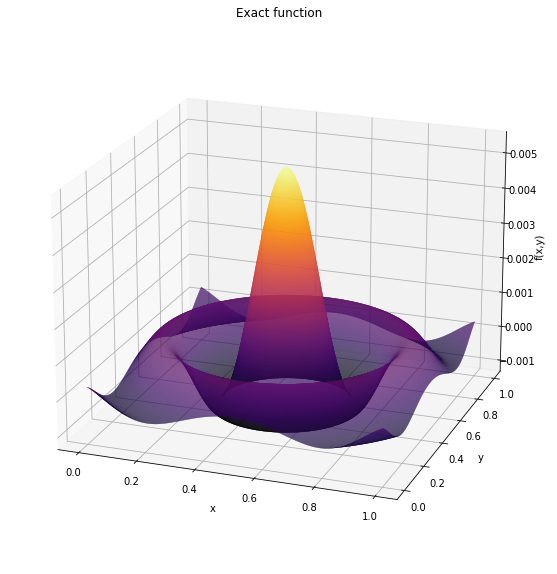

In [10]:
Y, X = np.meshgrid(y, x)
Z=np.array(target_f)

fig = plt.figure()
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.view_init(20, 290)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('Exact function')

Text(0.5, 0.92, 'Simulated function')

<Figure size 432x288 with 0 Axes>

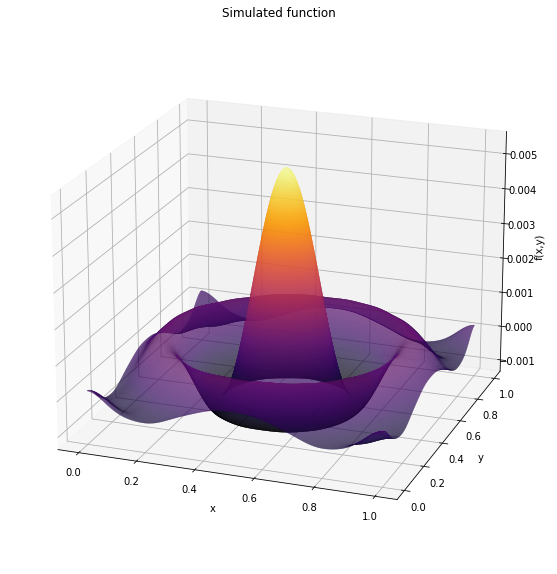

In [12]:
Y, X = np.meshgrid(y, x)
Z=np.real(np.array(simulated_f))

fig = plt.figure()
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.view_init(20, 290)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('Simulated function')

## Conclusion

In this notebook, we have performed the simulation of the FSL method for a two-dimensional sinc function. The code that we have provided in this notebook can be reused to load any function of two variables using the FSL method. 